In [1]:
import xmltodict, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import xmltodict
import pprint

In [2]:
# 与えられたnode idから対応するX,Yの点を返す関数
def findXY(nodes, node_id):
    for node in nodes:
        if node['@nid'] == str(node_id):
            return (node['@x'], node['@y'])

In [3]:
# 4点から面積を計算する方法（靴紐の公式））
# ✅ 例: 4点を指定して計算
# points = [(1, 1), (4, 1), (4, 5), (1, 5)]  # 長方形
# print(shoelace_area(points))  # 出力: 12.0
def shoelace_area(points):
    """
    計算順に並んだ4点の(x, y)座標リスト [(x1, y1), (x2, y2), (x3, y3), (x4, y4)] から面積を求める
    """
    n = len(points)
    area = 0
    for i in range(n):
        j = (i + 1) % n  # 次の点（最後の点は最初の点につなげる）
        area += points[i][0] * points[j][1] - points[i][1] * points[j][0]
    return abs(area) / 2

In [4]:
def nu_sigma(sigma_i):
    sigma_x = sigma_i[0]
    sigma_y = sigma_i[1]
    tau_xy = sigma_i[2]
    nu_sigma_x =  sigma_x      - nu * sigma_y
    nu_sigma_y = -nu * sigma_x + sigma_y
    nu_tau_xy =  2*(1+nu)*tau_xy 
    return np.array([nu_sigma_x, nu_sigma_y, nu_tau_xy])
    

In [5]:
def calc_g(rhos, vs, V0):
    g = np.dot(rhos, vs.transpose()) - a*V0
    return g 

In [6]:
def calc_rho_i(lmbda, sigma_i):
    rho_i = (-(n-1)/E0 * np.dot(nu_sigma(sigma_i), sigma_i.transpose())  / lmbda ) ** (1/n)
    if rho_i > 1:
        rho_i = 1 
    elif rho_i < 0.01:
        rho_i = 0.01
    return rho_i 

In [7]:
def calc_D(rho_i, lmbda, sigma_i):
    D = -lmbda * E0 * rho_i**n / ((n-1) * np.dot(nu_sigma(sigma_i), sigma_i.transpose()))
    return D

In [8]:
def update_rho_i(rho_i, lmbda, sigma_i, drho):
    D = calc_D(rho_i, lmbda, sigma_i)
    while abs(D-1) > 1e-3:
        if D > 1:
            rho_i = rho_i - drho 
        else:
            rho_i = rho_i + drho
        if rho_i > 1:
            rho_i = 1 
            break 
        elif rho_i < 0.01:
            rho_i = 0.01
            break 
        D = calc_D(rho_i,lmbda, sigma_i)
    return rho_i

In [9]:
def update_lambda(g, lmbda, dlambda):
    if g<0:
        lmbda = lmbda - dlambda #ラムダを右にシフト
        if lmbda > 0:
            lmbda = lmbda + dlambda #λは正にならないので、もし正になったら負に戻す
    else:
        lmbda = lmbda + dlambda #ラムダを左にシフト
    return lmbda 

In [10]:
def check_if_all_rhos_are_settled(rhos, ne):
    for i in range(ne):
        if (rhos[i] == 1) or (rhos[i] == 0.01):
            continue
        else:
            return False
    return True

In [11]:
def open_liml_file(liml_file_path):
    # Open the file and read the contents
    with open(liml_file_path,  'r', encoding='utf-8') as file:
        my_xml = file.read()
    # Use xmltodict to parse and convert 
    # the XML document
    my_dict = xmltodict.parse(my_xml).copy()
    # Print the dictionary
    # pprint.pprint(my_dict, indent=2)
    return my_dict

In [12]:
# グローバルなパラメータ
a = 0.375
E0 = 200e9
n = 2 #3が適当??
nu = 0.3

In [13]:
def run(base_filename):
    BASE_FILENAME = base_filename 
    #LISAファイルを開く
    data = 'input/'+BASE_FILENAME+'.liml'
    my_dict = open_liml_file(data)
    
    #要素リストの抽出
    elset = my_dict['liml8']['elset'].copy()
    if type(elset)==dict:
        elem_list = elset['elem']
    elif type(elset)==list:
        elem_list = []
        for e in elset:
            if "elem" in e:
                elem_list.append(e['elem'])
    # FEMの結果を変数に格納
    nodes = my_dict['liml8']['node'].copy() #nodes
    result_elems = my_dict['liml8']['solution']['results']['elem'].copy()
    ne = len(elem_list)
    sigmas = np.zeros((ne,3))
    # ρの初期化。初回か２回目以降かで異なる。
    if type(elset)==dict: #初回
        rhos = np.ones(ne) * a #初回はすべて平均値のaで代替する。
    elif type(elset)==list: #２回目以降
        mat_list = my_dict['liml8']['mat'].copy()
        E = np.array([x['mechanical']['@youngsmodulus'] for x in mat_list[1:]], dtype=np.double)
        rhos = (E/E0) ** (1/n)
    Es = np.zeros(ne)
    vs = np.zeros(ne)
    cxs = np.zeros(ne)
    cys = np.zeros(ne)
    # Load stress from each element
    lambda_tmp = 0
    for i in range(ne):
        Es[i] = rhos[i]**n * E0
        sigma_x = np.array(list(map(lambda x: x['@stressxx'], result_elems[i]['localnode'])),dtype=np.double).sum()
        sigma_y = np.array(list(map(lambda x: x['@stressyy'], result_elems[i]['localnode'])),dtype=np.double).sum()
        tau_xy = np.array(list(map(lambda x: x['@stressxy'], result_elems[i]['localnode'])),dtype=np.double).sum()
        sigmas[i] = np.array([sigma_x,sigma_y,tau_xy])
        lambda_tmp += np.dot(nu_sigma(sigmas[i]), sigmas[i].transpose())/(rhos[i]**n)
        node_ids = elem_list[i]['@nodes'].split(' ')
        vertices = np.zeros((4, 2))
        n_nodes_in_elems = len(node_ids)
        for j in range(n_nodes_in_elems):
            (x,y) = findXY(nodes, node_ids[j])
            vertices[j, :] = (x,y)
        vs[i] = shoelace_area(vertices)
        cxs[i] = vertices[:,0].sum() / n_nodes_in_elems 
        cys[i] = vertices[:,1].sum() / n_nodes_in_elems 
    
    # トータルの体積V0
    V0 = vs.sum()  
    # lambda_barはlmbdaの初期値
    lambda_bar = -1/ne*(n-1)/E0 * lambda_tmp     
    lmbda = lambda_bar
    #WARNING: dlambda is negative. The original reference recommends to make it positive using abs() function. 
    #Update rule of lambda needs to be modified if dlambda is positive.
    dlambda = 0.1 * lambda_bar
    drho = 0.05
    
    tolerance = 0.01 
    g_prev = 0
    g_res = []
    l_res = []
    is_dump_enabled = False 
    for i in range(ne):
        if is_dump_enabled: print(str(i)+'th element')
        lmbda = lambda_bar
        # λを更新するアウターループ
        while True:
            # λにしたがってρiを計算する
            rhos[i] = calc_rho_i(lmbda, sigmas[i])
            # ρを更新するインナーループ
            rhos[i] = update_rho_i(rhos[i], lmbda, sigmas[i], drho)
            if check_if_all_rhos_are_settled(rhos, ne): 
                if is_dump_enabled: print("***All rhos are settled.***") 
                break 
            g = calc_g(rhos, vs, V0)
            lmbda = update_lambda(g, lmbda, dlambda)
            if g==g_prev: #gに変化が見られない場合、λの最適解と判定、
                if is_dump_enabled: print("  No change in g.") 
                break
            if abs(g/V0) < tolerance: #gが0に近づいたらλの最適解と判定
                if is_dump_enabled: print("  g is almost zero") 
                break
            if g*g_prev< 0: #gの符号が変わったらラムダの最適解と判定
                if is_dump_enabled: print("  Sign of g changed.") 
                break
            g_prev = g
        # if is_dump_enabled: print(f"  g/V0: {g/V0}, λ:{lmbda}") 
        g_res.append(g)
        l_res.append(lmbda)
    plt.rcParams['figure.figsize'] = [8, 2]
    plt.subplot(1,2,1)    
    plt.plot(range(ne), g_res)
    plt.title('g')
    plt.xlabel('i-th element')
    plt.ylabel('g')
    plt.subplot(1,2,2)    
    plt.plot(range(ne), l_res)
    plt.title('lambda')
    plt.xlabel('i-th element')
    plt.ylabel('lambda')
    
    Ei = (rhos**n) * E0
    [X,Y] = np.meshgrid(np.linspace(min(cxs),max(cxs),100),np.linspace(min(cys),max(cys),100))
    points = np.concatenate((cxs[:, np.newaxis] , cys[:, np.newaxis]), axis=1)
    Z = griddata(points,-Ei,(X,Y))
    plt.rcParams['figure.figsize'] = [5, 5]
    fig, ax = plt.subplots() 
    plt.axis('off')
    img = ax.imshow(Z, extent=[min(cxs), max(cxs), min(cys), max(cys)])
    img.set_cmap('gray')
    
    
    # マテリアルの情報を更新する
    mat_base = my_dict['liml8']['mat'].copy()
    if type(mat_base)==list:
        mat_base = mat_base[0]
    id_base = mat_base['@mid']
    name_base = mat_base['@name']
    geo_base = mat_base['geometric']
    mech_base = mat_base['mechanical'] 
    mat_new = [mat_base.copy()]
    for i in range(ne):
        mat_dict = {}
        mat_dict['@mid'] = str(int(id_base) + i + 1)
        mat_dict['@name'] = name_base + str(int(id_base) + i)
        mat_dict['geometric'] = geo_base.copy()
        mat_dict['mechanical'] = mech_base.copy()
        # Update Young's modulus
        mat_dict['mechanical']['@youngsmodulus'] = "{:.0f}".format(Ei[i])
        mat_new.append(mat_dict)
    
    # 要素のマテリアル情報を更新する
    elem_base = my_dict['liml8']['elset'].copy()
    if type(elem_base)==list:
        elem_base = elem_base[0]
    elem_base.pop('elem', None) # Remove "elem" key
    elset_new = [elem_base]
    for i in range(ne):
        elem = elem_list[i]
        elem_dict = elem_base.copy() 
        elem_dict['elem'] = elem
        elem_dict['@name'] = 'Component'  + str (i + 1)
        elem_dict['@material'] = elem_base['@material'] + str(i + 1)
        elset_new.append(elem_dict)
    
    #結果の更新
    my_dict_new = my_dict.copy()
    my_dict_new['liml8']['elset'] = elset_new
    my_dict_new['liml8']['mat'] = mat_new
    
    liml = xmltodict.unparse(my_dict_new, pretty=True, full_document=False)
    output_filename = 'output/'+BASE_FILENAME+'_out.liml'
    fout = open(output_filename, 'w')
    fout.write(liml)
    fout.close()


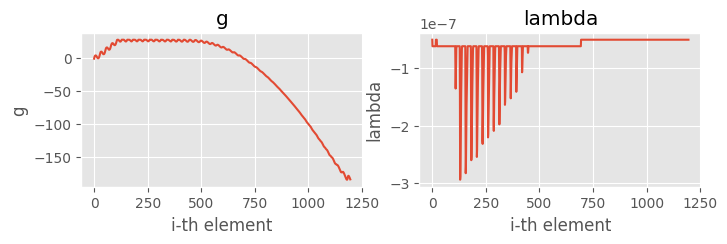

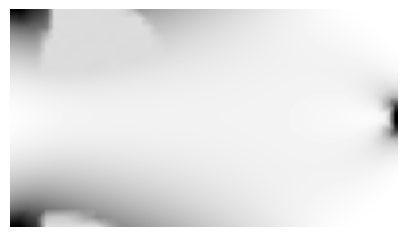

In [14]:
run('gen1')

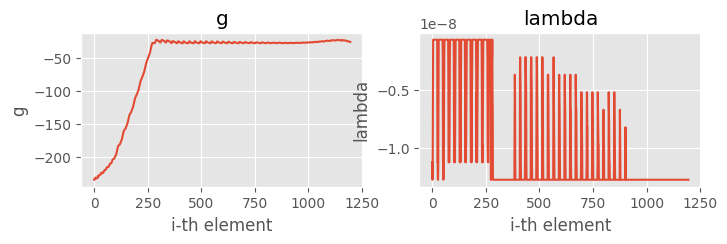

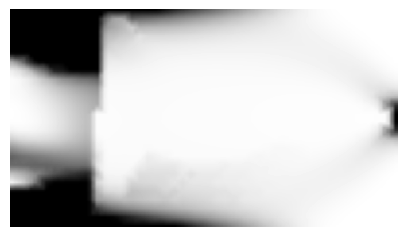

In [75]:
run('gen2')

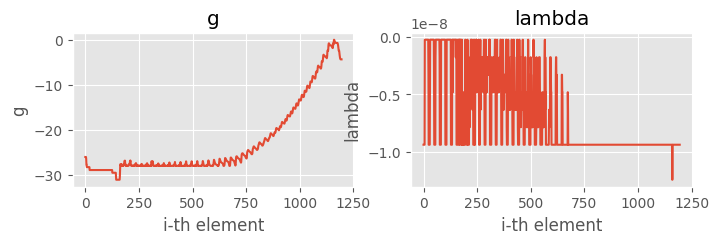

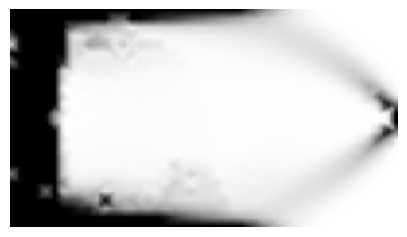

In [76]:
run('gen3')

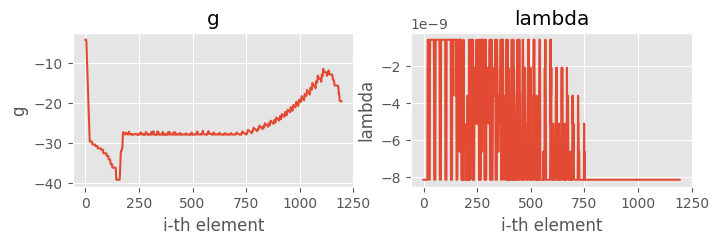

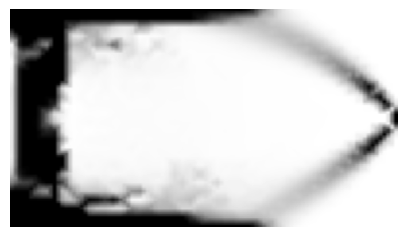

In [77]:
run('gen4')

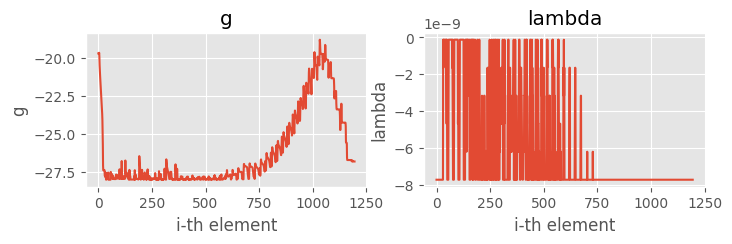

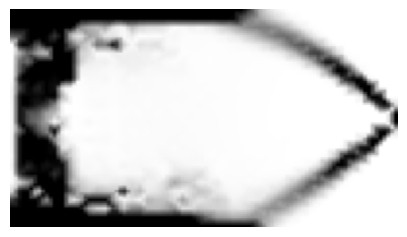

In [78]:
run('gen5')

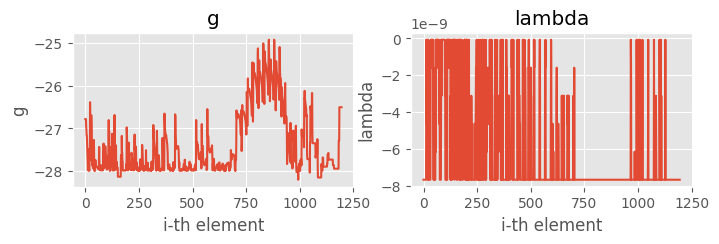

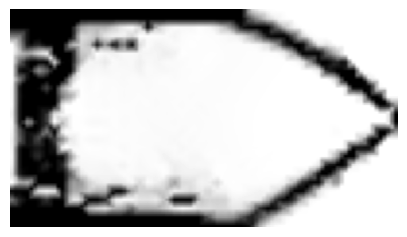

In [80]:
run('gen6')

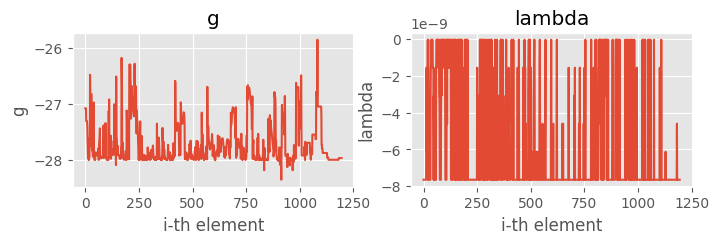

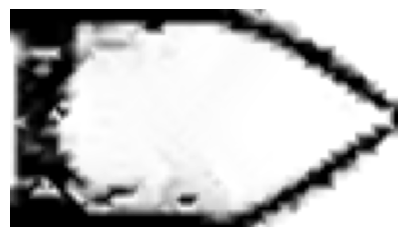

In [81]:
run('gen7')

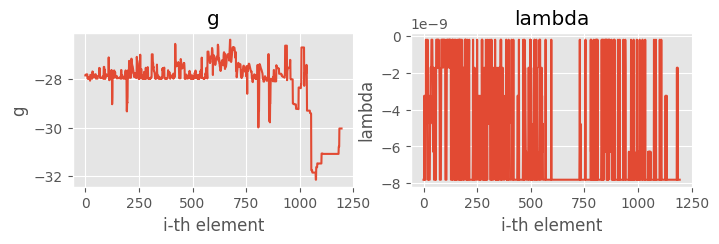

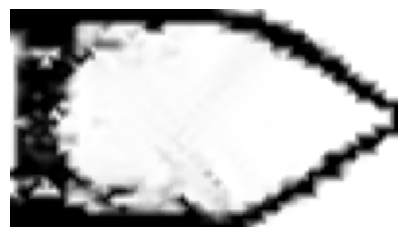

In [82]:
run('gen8')

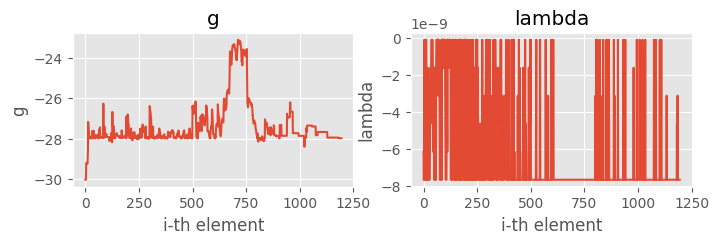

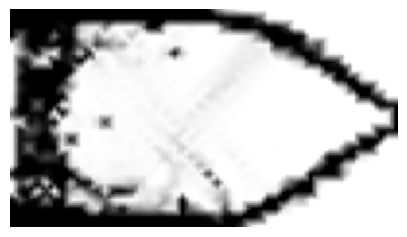

In [83]:
run('gen9')

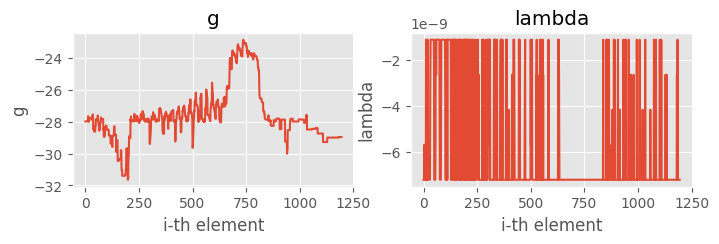

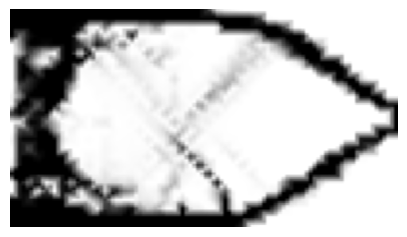

In [84]:
run('gen10')

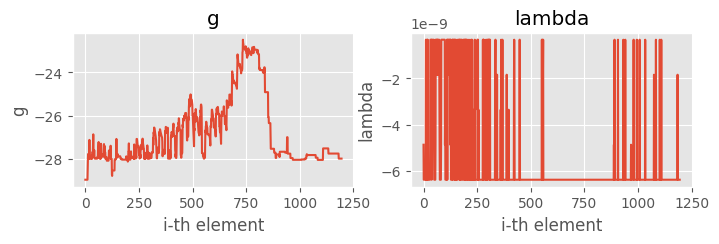

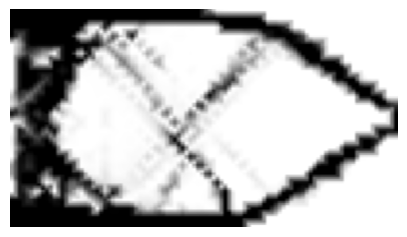

In [85]:
run('gen11')

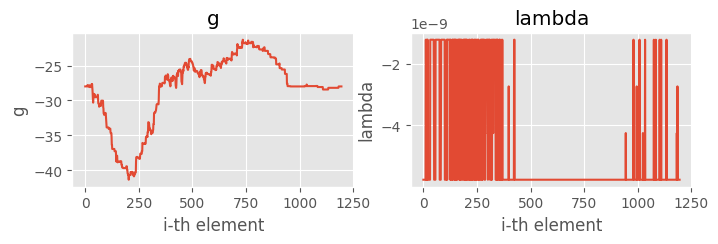

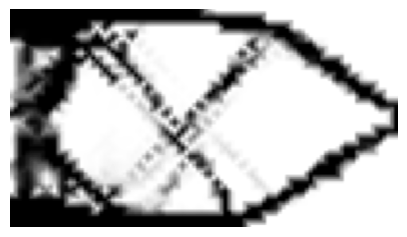

In [86]:
run('gen12')

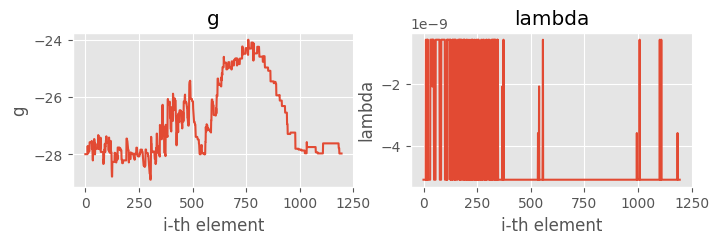

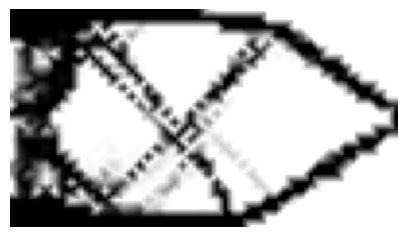

In [87]:
run('gen13')

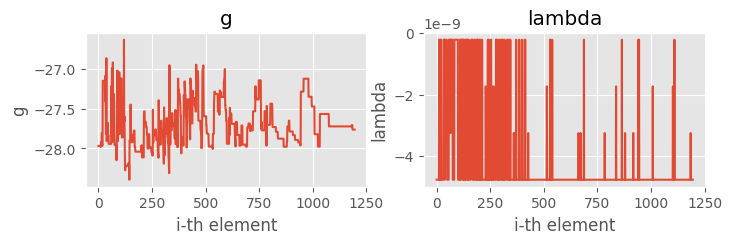

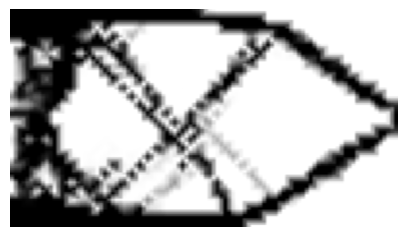

In [88]:
run('gen14')

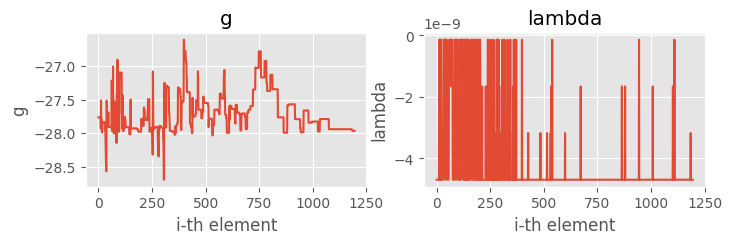

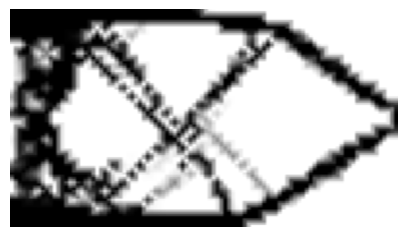

In [89]:
run('gen15')

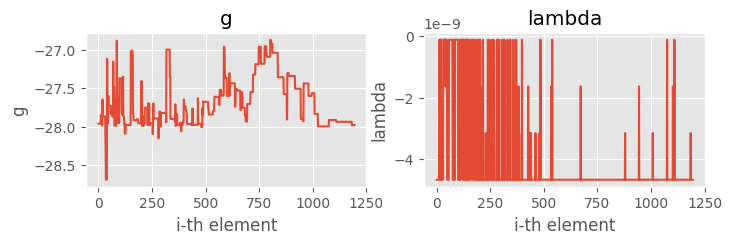

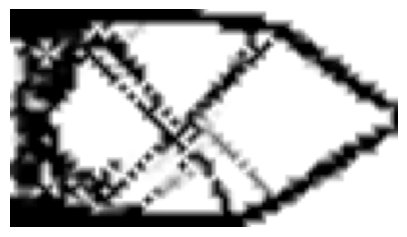

In [90]:
run('gen16')